In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import requests
from io import StringIO
import numpy as np
import gc

orig_url='https://drive.google.com/file/d/1OWRqfE-YXWja5XWRjl6pgV-hDdW0dG-k/view'

file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
df = pd.read_csv(csv_raw)

In [ ]:
df.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,year,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,378451.0,20,BlockedShot,0.876,0.602,0.019479,Ollie Watkins,h,8865,OpenPlay,2020,Head,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,Matthew Cash,Aerial
1,378458.0,54,MissedShots,0.878,0.430,0.031428,Ollie Watkins,h,8865,OpenPlay,2020,Head,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,TrÃ©zÃ©guet,Cross
2,378464.0,77,MissedShots,0.858,0.679,0.060696,Ollie Watkins,h,8865,OpenPlay,2020,RightFoot,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,John McGinn,Pass
3,379954.0,34,MissedShots,0.831,0.655,0.127710,Ollie Watkins,a,8865,OpenPlay,2020,RightFoot,14114,Fulham,Aston Villa,0,3,2020-09-28 17:00:00,Jack Grealish,TakeOn
4,379956.0,46,MissedShots,0.943,0.500,0.445354,Ollie Watkins,a,8865,FromCorner,2020,Head,14114,Fulham,Aston Villa,0,3,2020-09-28 17:00:00,Conor Hourihane,Cross


### Feature Engineering and Cleaning Data

In [ ]:
%%time

target = 'isGoal'

def get_angle(b):
    b = np.array(b)
    a = np.array([100,45])
    c = np.array([100,55])
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

df = df[~df['result'].isin(['BlockedShot', 'OwnGoal'])]

df[target] = df['result'].map({'MissedShots': 0, 
                               'SavedShot': 0, 
                               'ShotOnPost': 0, 
                               'Goal': 1})

df["h_state"] = np.where(df["h_goals"]==df["a_goals"], 2, np.where(df["h_goals"]>df["a_goals"], 1, 0)) ##get home state
df["a_state"] = df["h_state"].map({2:2, 1:0, 0:1}) ##get away state by inverting home state

df["game_state"] = np.where(df["h_a"]=='h', df["h_state"], df["a_state"]) ##get game_state of given team (h/a)
df.drop(["a_goals", "h_goals", "h_a"], axis=1, inplace=True) ##drop the columns we don't need anymore
df["shotType"] = df["shotType"].map({'RightFoot':0, 
                                        'LeftFoot':0,
                                        'OtherBodyPart':2, 
                                        'Head':1}) ##map to bodypart

df["situation"] = df["situation"].map({"OpenPlay": 0,
                                        "FromCorner":1, 
                                        "SetPiece": 2, 
                                        "DirectFreekick": 3}) ##map to situations

df["minute"] = df["minute"]/90.0    ###normalising doesn't matter in gradient-boosted tree models but it's a good practice anyway  


df[["X", "Y"]] = df[["X", "Y"]]*100
df["goal_x"] = 100
df["goal_y"] = 50
df["length"] = np.sqrt( np.square(df["goal_x"] - df["X"]) + np.square(df["goal_y"] - df["Y"]) )
df["angle"] = df[["X", "Y"]].apply(get_angle, axis=1)

CPU times: user 8.11 s, sys: 83.6 ms, total: 8.19 s
Wall time: 8.22 s


In [ ]:
df.head()

,id,minute,result,X,Y,xG,player,player_id,situation,year,shotType,match_id,h_team,a_team,date,player_assisted,lastAction,isGoal,h_state,a_state,game_state,goal_x,goal_y,length,angle
1,378458.0,0.600000,MissedShots,87.800003,43.000000,0.031428,Ollie Watkins,8865,0.0,2020,1,14104,Aston Villa,Sheffield United,2020-09-21 17:00:00,TrÃ©zÃ©guet,Cross,0,1,0,1,100,50,14.065558,35.216557
2,378464.0,0.855556,MissedShots,85.800003,67.900002,0.060696,Ollie Watkins,8865,0.0,2020,0,14104,Aston Villa,Sheffield United,2020-09-21 17:00:00,John McGinn,Pass,0,1,0,1,100,50,22.848413,15.943871
3,379954.0,0.377778,MissedShots,83.099998,65.500000,0.127710,Ollie Watkins,8865,0.0,2020,0,14114,Fulham,Aston Villa,2020-09-28 17:00:00,Jack Grealish,TakeOn,0,0,1,1,100,50,22.931639,18.645405
4,379956.0,0.511111,MissedShots,94.300003,50.000000,0.445354,Ollie Watkins,8865,1.0,2020,1,14114,Fulham,Aston Villa,2020-09-28 17:00:00,Conor Hourihane,Cross,0,0,1,1,100,50,5.699997,82.514054
5,381490.0,0.033333,Goal,91.599998,52.400002,0.510213,Ollie Watkins,8865,0.0,2020,0,14466,Aston Villa,Liverpool,2020-10-04 18:15:00,Jack Grealish,Pass,1,1,0,1,100,50,8.736134,58.577045


### Modelling

In [ ]:
from sklearn.model_selection import train_test_split

_ = gc.collect()
features = ['minute', 'X', 'Y', 'situation', 'shotType', 'game_state', 'length', 'angle']
target = 'isGoal'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1)


clf.fit(X_train, y_train, 
        eval_set=(X_test, y_test), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'learning_rate': 0.1, 'iterations': 5}


### Inference

In [ ]:
from sklearn.metrics import roc_auc_score
predictions = clf.predict(X_test)
print(f"Area under ROC curve: {roc_auc_score(predictions, y_test):.2f}")

Area under ROC curve: 0.79


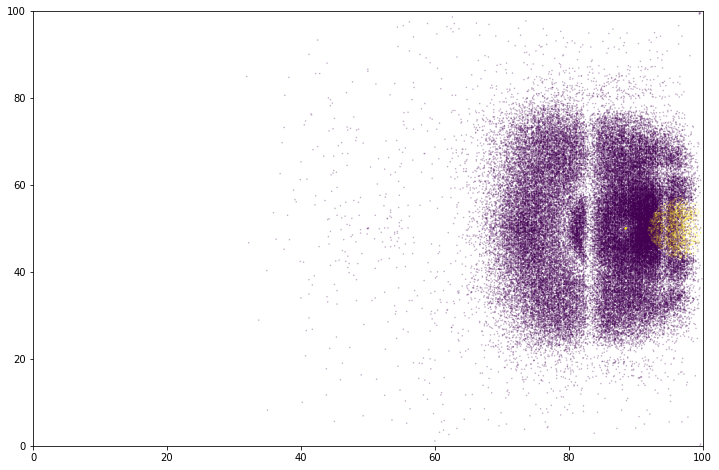

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
ax.set(xlim=(0,100), ylim=(0,100))
ax.scatter(X_test.X, X_test.Y, c=predictions, s=0.3, alpha=.3)